In [94]:
%matplotlib inline
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import censusgeocode as cg
import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor


from onoffgpf import OnOffSVGP, OnOffLikelihood

import gpflow
import tensorflow as tf

In [5]:
data_dir = '/mnt/c/Users/kheut/data/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [6]:


svi_file = os.path.join(result_dir,'svi_grid')
svi_gdf = gpd.read_file(svi_file)

deaths_gdf = svi_gdf

just_grid = deaths_gdf.loc[deaths_gdf['year']==2000, ['grid_squar','geometry', 'lat', 'lon']]



In [7]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [8]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors
    
# Make autoregressive feature
deaths_gdf_with_autoregressive = gpd.GeoDataFrame()
for year in range(2001, 2021):
    this_year = deaths_gdf[deaths_gdf['year']==year].set_index('grid_squar')
    last_year = deaths_gdf[deaths_gdf['year']==year-1].set_index('grid_squar')
    
    for grid_square in this_year.index.values:
        these_neighbors = last_year.loc[neighbors[grid_square],:]
        this_square = last_year.loc[grid_square,:]
        this_year.loc[grid_square, 'neighbor_t-1']  = these_neighbors['deaths'].mean()
        this_year.loc[grid_square, 'self_t-1']  = this_square['deaths'].mean()
        
    deaths_gdf_with_autoregressive = deaths_gdf_with_autoregressive.append(this_year)
    
deaths_gdf_with_autoregressive = deaths_gdf_with_autoregressive.reset_index()

In [9]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'year', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','year','deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'year', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','year','deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'year', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','year','deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'year', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','year','deaths']]

In [16]:
spatial_kernel = gpflow.kernels.RBF(2, active_dims=[0,1])
temporal_kernel = gpflow.kernels.RBF(1, active_dims=[2])
demo_kernel =  gpflow.kernels.RBF(7,active_dims=[3,4,5,6,7,8,9])
gaussian_kernel = spatial_kernel + temporal_kernel + demo_kernel

f_kernel = copy.deepcopy(gaussian_kernel)
g_kernel = copy.deepcopy(gaussian_kernel)


In [19]:
likelihood = OnOffLikelihood()

In [22]:
random = np.random.default_rng(seed=1)

In [24]:
M = 200
N = len(train_x_through_2018)
Z = random.choice(train_x_through_2018[['lat','lon','year','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values, size=M, replace=False)

Zf = copy.deepcopy(Z)
Zg = copy.deepcopy(Z)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_through_2018.loc[:, ['lat','lon','year','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']], 
                                                   train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1))).repeat().shuffle(N)


In [29]:
m = OnOffSVGP(train_x_through_2018.loc[:, ['lat','lon','year','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values,
              train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1)
              ,kernf=f_kernel,
              kerng=g_kernel
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,
              Zg = Zg
             )

# fix the model noise term
m.likelihood.variance = 0.01
m.likelihood.variance.fixed = False

In [54]:
%%time
m.optimize(maxiter = 2000) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
m.compute_log_likelihood()

CPU times: user 2h 35s, sys: 11min 16s, total: 2h 11min 52s
Wall time: 14min 52s


-30347.82534406638

In [55]:
sg_2019 = m.predict_onoffgp(x_just_2019.loc[:, ['lat','lon','year','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
sg_2019 = sg_2019[0]

In [56]:
sg_2019.min()

-0.20954095797495748

In [40]:
sg_2019[-1]

array([[0.0470545 ],
       [0.04608559],
       [0.04509999],
       [0.04409919],
       [0.04308438],
       [0.00468162],
       [0.00444176],
       [0.00107592],
       [0.00234098],
       [0.00131308],
       [0.00725842],
       [0.0013262 ],
       [0.00281695],
       [0.00265433],
       [0.00108442],
       [0.01565867],
       [0.08252405],
       [0.00107779],
       [0.00103453],
       [0.00437574],
       [0.00393127],
       [0.00692261],
       [0.00687112],
       [0.00638669],
       [0.00120093],
       [0.00896438],
       [0.02398255],
       [0.00159319],
       [0.00428227],
       [0.06700335],
       [0.06873555],
       [0.08206504],
       [0.00620519],
       [0.00113094],
       [0.00109763],
       [0.06812418],
       [0.06629741],
       [0.00293243],
       [0.00903931],
       [0.00838905],
       [0.01817396],
       [0.0449565 ],
       [0.04542732],
       [0.048807  ],
       [0.07830133],
       [0.00111878],
       [0.00104866],
       [0.001

In [57]:
pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019.grid_squar)


In [58]:
sg_MAE_2019 = mean_absolute_error(y_just_2019.deaths, pred_2019_df)

sg_MLAE_2019 = mean_log_absolute_error(y_just_2019.deaths, pred_2019_df)

sg_top_10_2019 = top_X(y_just_2019, pred_2019_df, 10)
sg_top_50_2019 = top_X(y_just_2019, pred_2019_df, 50)
sg_top_100_2019 = top_X(y_just_2019, pred_2019_df, 100)

In [73]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)
def top_X(y_true, y_pred, X=10):
    '''Makes ugly assumptions that y_true is a df with 
    GEOID and deaths columns.
    y_pred is a series with deaths as values and GEOID as index
    '''
    
    top_y_true = y_true.sort_values('deaths')[-X:]
    top_predicted_geoids = y_pred.sort_values()[-X:].index
    
    y_top_true_deaths =  top_y_true['deaths'].sum()
    
    y_top_predicted_deaths = y_true[y_true['grid_squar'].isin(top_predicted_geoids)]['deaths'].sum()
    
    return y_top_true_deaths - y_top_predicted_deaths, y_top_predicted_deaths/y_top_true_deaths

In [74]:
print(sg_MAE_2019 )

print(sg_MLAE_2019 )

print(sg_top_10_2019 [0])
print(sg_top_50_2019[0])
print(sg_top_100_2019 [0])
print(sg_top_10_2019 [1])
print(sg_top_50_2019[1])
print(sg_top_100_2019 [1])


0.8066578337995169
0.26931698785302155
16.0
26.0
73.0
0.9577836411609498
0.9730010384215991
0.9406504065040651


In [70]:
deaths_and_preds = y_just_2019.merge(pred_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

In [71]:
deaths_and_preds.loc[:,'residuals'] = deaths_and_preds.deaths-deaths_and_preds.pred_deaths

In [76]:
residual_gdf = just_grid.merge(deaths_and_preds, on='grid_squar')

Text(0.5, 1.0, '2019 Residuals from Sparse Zero-Inflated GP MAE 0.81')

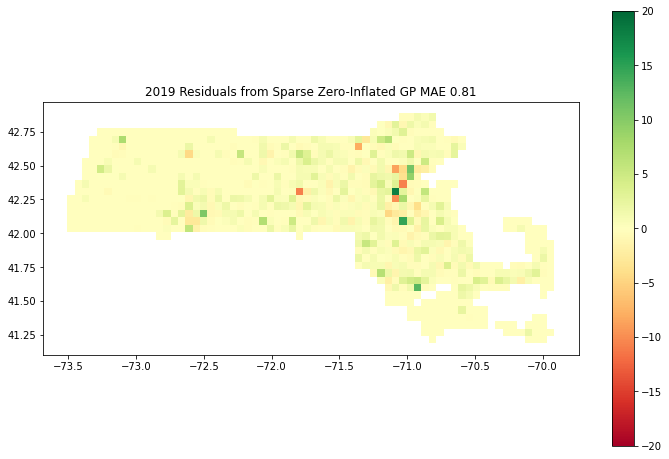

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
residual_gdf.plot(column='residuals', cmap='RdYlGn',ax=ax, legend=True,
                 vmin=-20, vmax=20)
plt.title(f'2019 Residuals from Sparse Zero-Inflated GP MAE {sg_MAE_2019:.2f}')


In [88]:
residual_gdf.residuals.min()

-10.929837603499301

In [92]:
comparisons = pd.read_csv(os.path.join(result_dir,'comparisons.csv'))
comparisons

,name,lat,lon,center,neighbors
0,N. Cambridge,42.3934,-71.1309,607,[581 582 583 606 607 608 631 632 633]
1,Jamaica Plain,42.3132,-71.1141,605,[579 580 581 604 605 606 629 630 631]
2,Springfield,42.1015,-72.5898,206,[191 192 193 205 206 207 219 220 221]
3,Pittsfield,42.4501,-73.2454,43,[29 30 31 42 43 44 56 57 58]
4,Brockton,42.0834,-71.0184,651,[625 626 627 650 651 652 678 679 680]
5,Lawrence,42.7070,-71.1631,612,[586 587 588 611 612 613 636 637 638]
6,Nantucket,41.2835,-70.0995,918,[911 917 918 919 928 929 930]
7,Falmouth,41.5532,-70.6086,848,[827 828 829 847 848 849 863 864 865]


Text(0.5, 1.05, 'Data for comparison locations, 2001-2019')

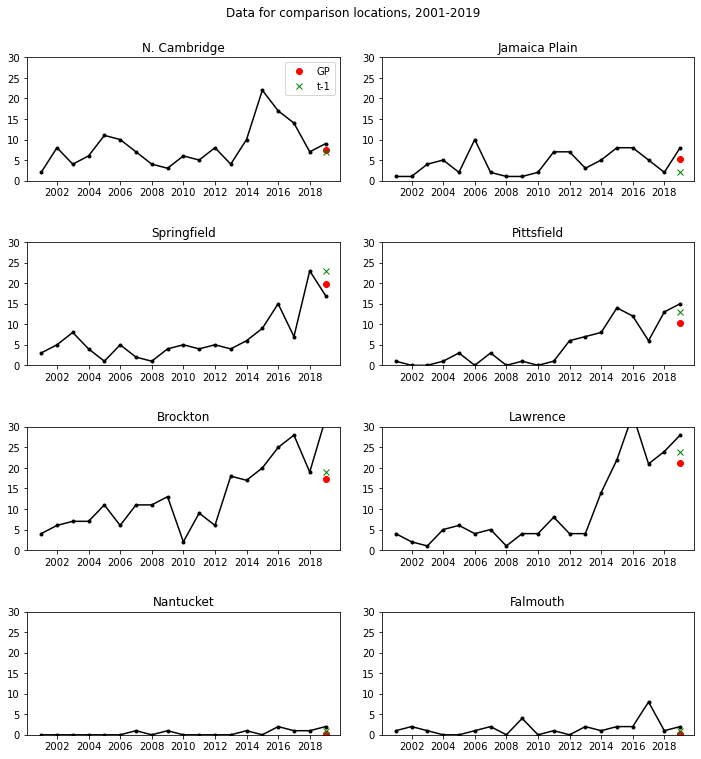

In [105]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for c, comparison in comparisons.iterrows():
    row = int(np.floor(c/2))
    col = c%2
    ax = axs[row, col]
    

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim([0,30])
    ax.set_title(comparison['name'])
        
    avg =  train_y_through_2019[train_y_through_2019['grid_squar']==comparison['center']].groupby('year').mean()['deaths']
    ax.plot(np.arange(2001, 2020), avg, 'k.-')
    
    ax.plot(2019, pred_2019_df.loc[comparison['center']],'ro', label='GP')
    ax.plot(2019,train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths'],'gx', label='t-1')
    if row==col==0:
        ax.legend()
fig.suptitle("Data for comparison locations, 2001-2019",y=1.05)

In [96]:
pred_2019_df

grid_squar
0      0.000336
1      0.000456
2      0.000477
3      0.000445
4      0.000415
         ...   
957    0.132581
958    0.021528
959    0.090112
960    0.000920
961    0.000781
Length: 962, dtype: float64

In [100]:
train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths']

,grid_squar,year,deaths
17202,848,2018,1.0
